In [3]:
%matplotlib inline

In [4]:
import h5py
import numpy as np
from Find_Blob_DoG import Num_Blob, find_blob_DoG
import plot_data
import Blob_detected_plot

### Divide Image 

In [5]:
with h5py.File('../Data_Kevin.hdf5', 'r') as f:
    nx, ny, nc, nt = f['Data_5'].shape
    #img_divide = np.empty([nx,ny,nt])
    #for t in range(nt):
    #    img_divide[:,:,t] = np.divide(f['Data_5'][:,:,2,t], f['Analysis']['img_median_Red'])

### Checking dataset in file

In [ ]:
with h5py.File('../Data_Kevin.hdf5', 'r') as f:
    print([key for key in f['Img_divided'].keys()])

### Removing a dataset

In [ ]:
with h5py.File('../Data_Kevin.hdf5', 'a') as f:
    g2 = f['Img_divided']
    g2.__delitem__('img_divide_data_2_Green_bis')

### Saving a dataset

In [ ]:
with h5py.File('../Data_Kevin.hdf5', 'a') as f:
    g2 = f['Img_divided']
    g2.create_dataset('img_divide_data_5_Red', data = img_divide, shape=img_divide.data.shape, chunks=True)

### Loading data

In [5]:
with h5py.File('../Data_Kevin.hdf5', 'r') as f:
    img_divide_Green = f['Img_divided']['img_divide_data_3_Green'][()]
    img_divide_Red = f['Img_divided']['img_divide_data_3_Red'][()]

### Analysis

#### Tile 3 : 
 - Green Thresh = 0.95
 - Red Thresh = 1.2
 
#### Tile 4 : 
 - Green Thresh = 0.9
 - Red Thresh = 1.2
 
#### Tile 5 : 
 - Green Thresh = 0.9
 - Red Thresh = 1.2
 
#### Tile 6 : 
 - Green Thresh = 0.95
 - Red Thresh = 1.2

In [6]:
Green = Num_Blob(img_divide_Green, nt, thresh = 0.9)

In [7]:
Red = Num_Blob(img_divide_Red, nt, thresh = 1.2)

In [8]:
blob_Green, list_num_blob_Green = Green

In [9]:
blob_Red, list_num_blob_Red = Red

### Save txt file

In [10]:
with open('Green_Tile4.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(str(line) for line in list_num_blob_Green))

In [11]:
with open('Red_Tile4.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(str(line) for line in list_num_blob_Red))

### Open txt file

In [ ]:
with open('Red_Tile5.txt') as f:
    list_num_blob_Red = f.read().splitlines()
    list_num_blob_Red = [int(i) for i in list_num_blob_Red]
with open('Green_Tile5.txt') as f:
    list_num_blob_Green = f.read().splitlines()
    list_num_blob_Green = [int(i) for i in list_num_blob_Green]

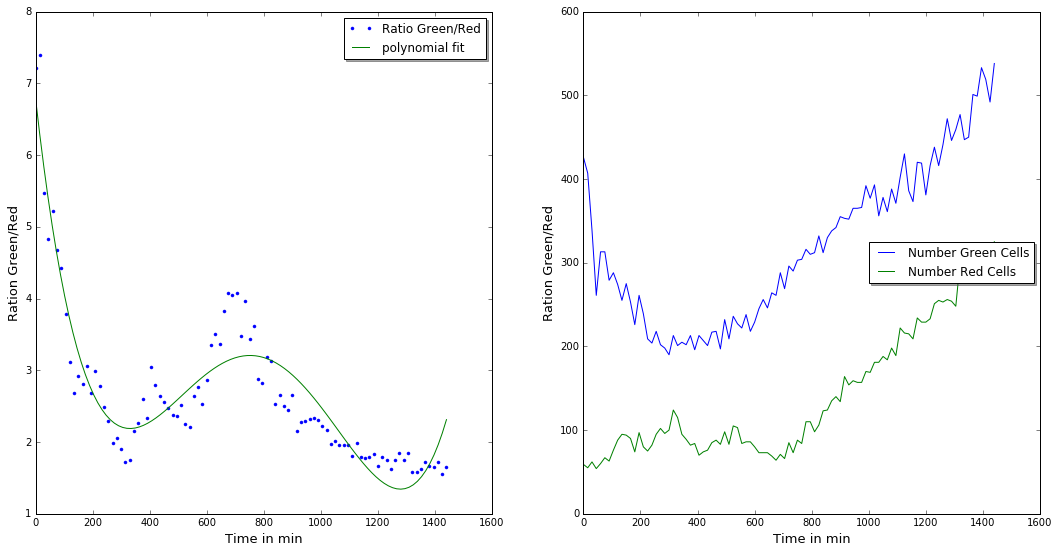

In [12]:
plot_data.plot(list_num_blob_Green, list_num_blob_Red)

In [ ]:
plot_data.plot(list_num_blob_Green, list_num_blob_Red)

### That part is for checking the threshold

In [6]:
from math import *
from scipy.ndimage import gaussian_filter
import itertools as itt
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist

In [29]:
def find_max(image, x):
    J = np.zeros(image.shape, dtype=bool)
    J[1:-1,1:-1,x] = ((image[1:-1,1:-1,x] > image[ :-2, :-2,x]) & (image[1:-1,1:-1,x] > image[ :-2, 1:-1,x]) & (image[1:-1,1:-1,x] > image[ :-2,2:,x]) &
                      (image[1:-1,1:-1,x] > image[1:-1, :-2,x]) &                                      (image[1:-1,1:-1,x] > image[1:-1,2:,x]) &
                      (image[1:-1,1:-1,x] > image[2:  , :-2,x]) & (image[1:-1,1:-1,x] > image[2:  , 1:-1,x]) & (image[1:-1,1:-1,x] > image[2:  ,2:,x]))
    
    J[1:-1,1:-1,(x-1)] = ((image[1:-1,1:-1,x] > image[ :-2, :-2,(x-1)]) & (image[1:-1,1:-1,x] > image[ :-2, 1:-1,(x-1)]) & (image[1:-1,1:-1,x] > image[ :-2,2:,(x-1)]) &
                      (image[1:-1,1:-1,x] > image[1:-1, :-2,(x-1)]) & (image[1:-1,1:-1,x] > image[1:-1, 1:-1,(x-1)]) & (image[1:-1,1:-1,x] > image[1:-1,2:,(x-1)]) &
                      (image[1:-1,1:-1,x] > image[2:  , :-2,(x-1)]) & (image[1:-1,1:-1,x] > image[2:  , 1:-1,(x-1)]) & (image[1:-1,1:-1,x] > image[2:  ,2:,(x-1)]))
    
    J[1:-1,1:-1,(x+1)] = ((image[1:-1,1:-1,x] > image[ :-2, :-2,(x+1)]) & (image[1:-1,1:-1,x] > image[ :-2, 1:-1,(x+1)]) & (image[1:-1,1:-1,x] > image[ :-2,2:,(x+1)]) &
                      (image[1:-1,1:-1,x] > image[1:-1, :-2,(x+1)]) & (image[1:-1,1:-1,x] > image[1:-1, 1:-1,(x+1)]) & (image[1:-1,1:-1,x] > image[1:-1,2:,(x+1)]) &
                      (image[1:-1,1:-1,x] > image[2:  , :-2,(x+1)]) & (image[1:-1,1:-1,x] > image[2:  , 1:-1,(x+1)]) & (image[1:-1,1:-1,x] > image[2:  ,2:,(x+1)]))
    
    return J[:,:,x] & J[:,:,x-1] & J[:,:,x+1]

In [41]:

def find_blob_DoG(image):

    min_sigma=5
    max_sigma=50
    sigma_ratio=1.6

    k = int(log(float(max_sigma) / min_sigma, sigma_ratio)) + 1

        # a geometric progression of standard deviations for gaussian kernels
    sigma_list = np.array([min_sigma * (sigma_ratio ** i)for i in range(k + 1)])

    gaussian_images = [gaussian_filter(image, s) for s in sigma_list]

        # computing difference between two successive Gaussian blurred images
        # multiplying with standard deviation provides scale invariance
    dog_images = [(gaussian_images[i] - gaussian_images[i + 1])* sigma_list[i] for i in range(k)]
    image_cube = np.dstack(dog_images)

    maxima = []
    for n in range(1, 4):
        maxima.append(find_max(image_cube, n))
    arr = np.array(maxima)    


    arr &= image > 1.2
    
    local_maxima = np.argwhere(np.bitwise_or.reduce(arr))
    add = np.zeros(local_maxima[:,0].shape)
    local_maxima = np.concatenate((local_maxima, add[:,np.newaxis]), axis=1).astype("int64")
    

    
    for blob1, blob2 in itt.combinations(local_maxima, 2):
        d = hypot(blob1[0] - blob2[0], blob1[1] - blob2[1])
        if d < 30 :
            blob2[2] = -1
           
    
    return np.array([b for b in local_maxima if b[2] >= 0])

In [42]:
local_maxima_me = find_blob_DoG(img_divide_Red[:,:,0])

In [ ]:
img_eq = equalize_hist(img_divide_Red[:,:,90])

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(40, 30))
fig.suptitle("First Tile",weight = "bold", fontsize=25, y = 0.88)
axes.imshow(img_eq, cmap='gray',interpolation='nearest')
axes.scatter(local_maxima_me[:,1], local_maxima_me[:,0], marker='o', facecolors='none', edgecolors='r', label = "Counted Green Cells")
axes.legend(loc=0, fontsize=25, shadow=True)
axes.axis("off")
axes.autoscale_view('tight')

In [9]:
import cProfile

In [39]:
cProfile.run('find_blob_DoG(img_divide_Red[:,:,0])')

         10983 function calls (10957 primitive calls) in 0.013 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:996(_handle_fromlist)
        1    0.000    0.000    0.013    0.013 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 <string>:12(__new__)
       21    0.000    0.000    0.000    0.000 _collections_abc.py:599(__contains__)
        1    0.000    0.000    0.000    0.000 _collections_abc.py:611(items)
        4    0.000    0.000    0.000    0.000 _collections_abc.py:615(values)
        5    0.000    0.000    0.000    0.000 _collections_abc.py:631(__init__)
       26    0.000    0.000    0.000    0.000 _collections_abc.py:675(__iter__)
      728    0.001    0.000    0.001    0.000 _collections_abc.py:692(__iter__)
        4    0.000    0.000    0.000    0.000 _weakrefset.py:70(__contains__)
        2    0.000    0.000    0.000 

AttributeError: Failed at object (analyzing bytecode)
'DataFlowAnalysis' object has no attribute 'op_STORE_DEREF'

In [20]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [31]:
%lprun -f find_blob_DoG find_blob_DoG(img_divide_Red[:,:,0])

In [17]:
from numba import jit